# Perform a Lesion Network Mapping GLM using FSL's PALM

### Authors: Alexander Cohen, Christopher Lin

Use this to run/test a statistical model (e.g., regression or T-tests) on lesion network maps (or lesions alone!) using PALM, potentially taking into account specific covariates of interest and/or nuisance regressors.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)
- This notebook is a combination of the old PALM Notebooks and Christopher's palm_analysis notebooks (does the same thing) and requires the NIMLAB Python 3 environment as a kernel. Directions are on the [NIMLAB software_env README.md](https://github.com/nimlab/software_env)
- You will need a csv file that provides the paths to your fcMaps, usually created from the [Preprocessing](https://github.com/nimlab/templates/blob/master/py3_notebooks/1_Preprocessing_LesionQA_fcGen_XNATupload.ipynb) or [xnat_grabber](https://github.com/nimlab/templates/blob/master/xnat_grabber.ipynb) notebooks.
- Christopher wrote up a really nice description of how to modify code to set up your design matrix within the notebook here: [PALM-Analysis](https://github.com/nimlab/documentation/wiki/PALM-Analyses)
- I would also recommend reviewing Fred's [slides](https://github.com/nimlab/documentation/blob/master/presentations/presentation_palm_multidataset_analyses_labmeeting_13.4.2020.pdf) from his May 2020 lab meeting For details regarding the difference between implementing a random effects and fixed effects analysis and use of exchangeability blocks

In [1]:
## Packages and environmental settings:
##Packages:
import os
import sys
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from nilearn import image
from nimlab import software as sf
%matplotlib inline

In [2]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.width", None)
# pd.set_option("display.max_colwidth", None)

In [2]:
%env PATH="/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/lib/fsl/5.0:/cluster/2021ahussain/usr/share/fsl:/cluster/2021ahussain/palm:/cluster/2021ahussain/.local/bin:/cluster/2021ahussain/bin:/cluster/2021ahussain/usr/share/fsl/5.0:/cluster/2021ahussain/palm:/cluster/2021ahussain/usr/share/fsl/5.0:palm"

env: PATH="/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/snap/bin:/usr/lib/fsl/5.0:/cluster/2021ahussain/usr/share/fsl:/cluster/2021ahussain/palm:/cluster/2021ahussain/.local/bin:/cluster/2021ahussain/bin:/cluster/2021ahussain/usr/share/fsl/5.0:/cluster/2021ahussain/palm:/cluster/2021ahussain/usr/share/fsl/5.0:palm"


# Input/Output Setup

### 1. Provide your email address for future reference:

In [4]:
# Enter your email address here in quotes:
creator_email = "alexander.cohen2@childrens.harvard.edu"

### 2. Where are your data? and where do you want the results to go?
NOTES: 
- `dataset_csv` is the csv file created from the `Preprocessing` or `xnat_grabber` notebooks that points to your Lesions and fcMaps (will also work with older csv files from `xnat_gate`).
- If you are comparing multiple datasets, your csv should contain both, i.e., specify both in xnat_grabber, or just concatenate the files in excel, etc...
- Don't worry about any covariate variables yet, we'll get to that below...

In [3]:
# Specify the path to your dataset.csv file

# dataset_csv = "your_dataset_csv_file.csv"
# output_dir = "3_PALM_Analysis_of_datasetA_and_covariateB"

dataset_csv = "mgh_palm_dcn.csv"
output_dir = "mgh_palm_dcn"

clean_df = pd.read_csv(dataset_csv)

### Code to remove rows where a particular column has no data:
# clean_df.dropna(how='any', subset=['language_f'],inplace=True)
### Code to remove rows where a particular column has no data:

### Code for LOOCV computation
# Set LOOCV to True and run the notebook as an ipython script with a single argument
# (which row to drop, starts from 1 for the non-pythonic user)
LOOCV = False
if LOOCV:
    dropnumber=int(sys.argv[1])-1
    LOO_subject=clean_df.loc[dropnumber,'subject']
    LOO_lesion=clean_df.loc[dropnumber,'filename']
    print("I am going to Leave Out person #",sys.argv[1],"which was:",LOO_subject)
    clean_df.drop(dropnumber,inplace=True)
    output_dir = output_dir + "_" + sys.argv[1]
    print("Output will now be saved in",output_dir)
### Code for LOOCV computation

# Specify which files are to be used as input:
# This is usually 'func_T' but the other files could be used as well
# ('Lesion', 'AvgR', 'AvgR_Fz', or 'func_T')
input_imgs = clean_df['filenames']

working_dir = os.path.join(output_dir,"palm_config")
if not os.path.exists(working_dir):
    os.makedirs(working_dir)

print("I found", len(clean_df), "participants in", len(clean_df['dataset'].unique()),"different datasets:",clean_df['dataset'].unique())
print("")
print("Results will be stored in a sub-directory named: ",output_dir)
display(clean_df)

I found 488 participants in 1 different datasets: ['MGH']

Results will be stored in a sub-directory named:  mgh_palm_dcn


,dataset,rrsubject,mRS,NIHSS,filenames
0,MGH,1,0,2,mgh_rr_dcn/rrsubject001.nii
1,MGH,2,1,7,mgh_rr_dcn/rrsubject002.nii
2,MGH,3,6,31,mgh_rr_dcn/rrsubject003.nii
3,MGH,4,1,2,mgh_rr_dcn/rrsubject004.nii
4,MGH,5,1,1,mgh_rr_dcn/rrsubject005.nii
...,...,...,...,...,...
483,MGH,486,1,4,mgh_rr_dcn/rrsubject486.nii
484,MGH,487,0,1,mgh_rr_dcn/rrsubject487.nii
485,MGH,488,6,15,mgh_rr_dcn/rrsubject488.nii
486,MGH,489,0,0,mgh_rr_dcn/rrsubject489.nii


### 3. Create a design matrix

NOTES:
- The design matrix tells PALM about the statistical structure of your data
- Rows = subjects/maps/observations
- Columns = "explanatory variables" or EVs
    - EVs can be independent binary or continuous variables that you are interested in studying.
    - EVs can also be 'nuisance' variables you are not interested in (like lesion size, or type of data).
    - By including any EVs you think could effect the fcMaps, your statistical estimate for the EV of interest (your 'contrast' of interest) will be more specific and less likely to be due to a confound, but there are specific reasons to *not* include a nuisance variable from time to time.
- Examples:
    - [Two Sample T-Test](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29)
    - [One Sample with Covariate](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Average_with_Additional_Covariate)
    
Only run **ONE** of the following two sets of cells depending on how you want to create your design matrix:
- If you want to manually edit your design matrix, i.e., in Excel, choose **Option 1**.
- If you want to generate your design matrix with code, i.e., using Christopher's [examples](https://github.com/nimlab/documentation/wiki/PALM-Analyses), choose **Option 2**.
- **Both** options allow you to automatically add lesion sizes.

### OPTION ONE (part A) - If you are going to manually add your EVs, first use this cell:
NOTE: If a `dataset_phenotype.csv` already exists (you are re-running this notebook), the file will NOT be overwritten. If you want a new template to be created, delete the file first.

In [5]:
# This cell will create a template phenotype file that lists your files and the dataset and subject names:

# Do you want me to add lesion sizes to the phenotype file for you?
add_lesion_sizes = False

phenotype_csv = os.path.splitext(dataset_csv)[0]+"_phenotype.csv"

if not os.path.exists(phenotype_csv):
    template_design_matrix = clean_df[['dataset','rrsubject']].copy()
    template_design_matrix.insert(0,'files',input_imgs)
    if add_lesion_sizes:
        lesion_sizes=[]
        for lesion in tqdm(clean_df.Lesion):
            lesion_sizes.append(np.count_nonzero(np.nan_to_num(image.load_img(lesion, dtype="int16").get_fdata())))
        template_design_matrix['lesion_sizes']=lesion_sizes
    template_design_matrix.to_csv(phenotype_csv, index=False)
    print("")
    print("A Template Design Matrix (with labels) has been created at",phenotype_csv)
else:
    print("There is already a file named:",phenotype_csv)
    print("If you want to make a new one, delete this file first and re-run this cell.")


A Template Design Matrix (with labels) has been created at mgh_palm_dcn_phenotype.csv


### OPTION ONE (part B) - After you have manually added your EVs, then use this cell to load your modified phenotype.csv:
NOTE: Don't change the name, just edit/modify the file in place, and this code will load the content

In [7]:
# Load your modified phenotype file and create a design matrix from it:
design_matrix = pd.read_csv(phenotype_csv)
ordered_input_imgs=design_matrix['files']
design_matrix = design_matrix.drop(columns=['files','dataset','rrsubject'])

### OPTION TWO - If you are going to construct your design matrix using code, uncomment (Cmd+/ or Control+/) and use this cell:

The instructions/examples Christopher put together are on [GitHub](https://github.com/nimlab/documentation/wiki/PALM-Analyses), and the possible patterns are listed on the FSL [GLM website](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM).

- Typical Examples:
    - [Two Sample T-Test](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29)
    - [One Sample with Covariate](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Average_with_Additional_Covariate)

In [7]:
# # Modify this cell according to the documentation page:
# # https://github.com/nimlab/documentation/wiki/PALM-Analyses

# # Keep these two lines:
# design_matrix = pd.DataFrame()
# ordered_input_imgs=input_imgs


# coding_key = {"Corbetta_Lesions": 1}
# design_matrix["Intercept"] = clean_df['dataset'].replace(coding_key)

# design_matrix["language_f"] = clean_df['language_f'].copy()


# # Do you want to also add lesion sizes to the design matrix?
# add_lesion_sizes = True


# if add_lesion_sizes:
#     lesion_sizes=[]
#     for lesion in tqdm(clean_df.Lesion):
#         lesion_sizes.append(np.count_nonzero(np.nan_to_num(image.load_img(lesion, dtype="int16").get_fdata())))
#     design_matrix['lesion_sizes']=lesion_sizes

### 3b. Mean-Center your covariates
NOTES:
- This is described [here](http://mumford.fmripower.org/mean_centering/) and on the FSL FSL [GLM website](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM).
- Add lines as necessary for your covariates.
- Your 'dummy' variables (0 vs 1) for group membership do not need to bee mean-centered

In [8]:
### mean center any continous variables
# design_matrix['covariateA'] = design_matrix['covariateA'].sub(design_matrix['covariateA'].mean())  
# design_matrix['nihss_hospital'] = design_matrix['nihss_hospital'].sub(design_matrix['nihss_hospital'].mean())  

# ### mean center the lesion sizes AND divide by 1000 to get the numbers ~0-100s or so:
# # (According to Anderson, having values in the 10,000s could cause statistical weirdness...)
# design_matrix['lesion_sizes'] = design_matrix['lesion_sizes'].sub(design_matrix['lesion_sizes'].mean()).div(1000)

### 4. Show me what the design matrix looks like

I found 2 EVs IN THIS ORDER: ['int', 'nihss']


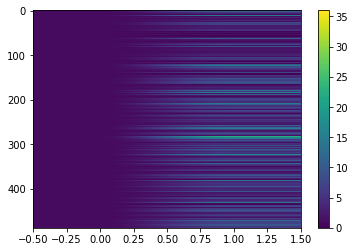

In [8]:
print("I found",len(design_matrix. columns),"EVs IN THIS ORDER:",list(design_matrix.columns))

if 'lesion_sizes' in design_matrix.columns:
    fig, axs = plt.subplots(1,2,sharey=True)
    a1 = axs[0].imshow(design_matrix.drop(columns=['lesion_sizes']), aspect='auto')
    a2 = axs[1].imshow(design_matrix.filter(['lesion_sizes']), aspect='auto')
    plt.colorbar(a1,ax=axs[0])
    plt.colorbar(a2,ax=axs[1])
    print("Plotting the lesion sizes separately b/c they overwhelm the 1s and 0s")
else:
    plt.imshow(design_matrix, aspect='auto')
    plt.colorbar()

### 5. Now, Create a contrast matrix

NOTES:
- Each 'contrast' is a statistical test where you are asking the question: **where** in the brain do the values behave like the single EV, or combination of EVs, that you specifiy in your contrast. This is also discussed on the FSL [GLM website](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM).
- Each 'contrast' is a short list of numbers, one per EV, typically +1,0,-1 that are **in the same order as the columns of your design matrix**.
- There are different ways to organize your design matrix and contrast matrix to achieve the same goals, this is where collaborating with someone who has done this before is important to make sure you are 'asking' the question you think you are asking.

In [9]:
# Modify this cell according to the documentation page:
# https://github.com/nimlab/documentation/wiki/PALM-Analyses

contrast_df = pd.DataFrame()

contrast_df['nihss'] = [0, 1]

contrast_matrix = contrast_df.T
print(contrast_matrix)
contrast_matrix.columns = design_matrix.columns
print("Each row is a contrast, each column is an EV:")
print("")
display(contrast_matrix)

       0  1
nihss  0  1
Each row is a contrast, each column is an EV:



,int,nihss
nihss,0,1


### 5b. (Optional) Generate exchangeability blocks if needed
NOTES:
- This is optional and for when you are doing a 'meta-analysis' of multiple data types, e.g. strokes and DBS sites
- This is a column of integers that can usually be generated from the dataset names. Details on the [PALM website](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/PALM/ExchangeabilityBlocks)
- To use this, add the following to the `call_palm` command below `eb=eb_matrix`.

In [11]:
### This is just an example, you will have to edit to adapt to your data, 
### but it should be integers, starting with 1,2,3....

# coding_key = {"Prosopagnosia_w_Yeo1000": 1,
#              "Corbetta_Lesions": 1,
#              "DBS_dataset": 2
#              }

# eb_matrix = pd.DataFrame()
# eb_matrix = clean_df['dataset'].replace(coding_key)
# display(eb_matrix)

### 6. FINALLY, Run PALM

NOTES:
- This can take awhile depending on the number of subjects and the number of contrasts, make sure you are running this in a 'protected' session, i.e., jupyter was run in a `tmux` session or an onDemand session.
- There are options for the `call_palm` function to allow for getting tfce-fwe results, using exchangeability blocks, 1-p, etc... See the documentation here: [GitHub](https://github.com/nimlab/documentation/wiki/PALM-Analyses)
    - `accel = "tail"` only applies to the FWE results, not the FDR or uncorrected results.
    - `corrcon_flag = True` does FWER-correction across all contrasts, taking into account any dependency that may exist between these contrasts.
    - **The default is to save 1-p maps**, but set `save_1p=False` and `logp=True` to instead save **-log10(p) maps**, i.e., 0.05 ~ 1.3, 0.01 ~ 2, 0.001 ~3, etc... which is **great** for visualization
    - ~5000 permutations is considered standard, running less, like ~1000 with tail acceleration on can be useful for testing, but *the uncorrected p values can be misleading* (more iterations = more precision, not more significance)

In [10]:
# Edit this according to documentation page

# Current best default settings:
sf.call_palm(ordered_input_imgs,
             design_matrix,
             contrast_matrix,
             working_dir,
             output_dir,
             1000,
             accel="tail",
             eb=None,
             mask="",
             save_1p=True,
             logp=False,
             tfce=False,
             ise_flag=False,
             two_tailed_flag=True,
             corrcon_flag=False,
             fdr_flag=False,
             cluster_submit="erisone_script")

# Settings that are more consistent with prior usage:
# sf.call_palm(ordered_input_imgs,
#              design_matrix,
#              contrast_matrix,
#              working_dir,
#              output_dir,
#              1000,
#              tfce=True,
#              fdr_flag=True,
#              accel="tail")


### Code for LOOCV execution, Should not need to change:
if LOOCV:
    LOO_dir = os.path.join(output_dir,"LOOCV_test")
    if not os.path.exists(LOO_dir):
        os.makedirs(LOO_dir)
    shutil.copy2(LOO_lesion,LOO_dir)

concatenating input...
Calling PALM with following command:
palm -i mgh_palm_dcn/palm_config/concat.nii -o mgh_palm_dcn/ -d mgh_palm_dcn/palm_config/design.mat -t mgh_palm_dcn/palm_config/contrast.con -n 1000 -m mgh_palm_dcn/palm_config/MNI152_T1_2mm_brain_mask_dil.nii -save1-p -twotail -accel tail
Script saved to: mgh_palm_dcn/palm_config/submit.sh


Time elapsed: 0 seconds


## 7. Clean up working directory

In [16]:
os.remove(os.path.join(working_dir,'concat.nii'))